In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras import Sequential, Model, optimizers
from keras.layers import Dense, Dropout, BatchNormalization, Input, Flatten
from keras.layers import Conv1D, GlobalAveragePooling1D, SimpleRNN, Bidirectional
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sn

# Import Data

In [11]:
dataset = pd.read_csv('data_nomean.csv', index_col=0)
dataset.tail()

,index,middle,ring,pinky,label
159995,"[0.20588235294117624, 0.20588235294117624, 0.2...","[0.902254409463127, 0.902254409463127, 0.90208...","[0.9900052169121742, 0.9900052169121742, 0.990...","[0.9963689704020832, 0.9963689704020832, 0.996...",4-4
159996,"[0.20517241379310305, 0.20517241379310305, 0.2...","[0.9019139943862396, 0.9019139943862396, 0.901...","[0.9896662412047679, 0.9896662412047679, 0.989...","[0.99636890657134, 0.99636890657134, 0.9963689...",4-4
159997,"[0.20309810671256565, 0.20309810671256565, 0.2...","[0.9015749535299048, 0.9015749535299048, 0.901...","[0.9893274045996283, 0.9893274045996283, 0.989...","[0.9963688975135385, 0.9963688975135385, 0.996...",4-4
159998,"[0.2013651877133101, 0.20307167235494875, 0.20...","[0.9007786395940026, 0.9007786395940026, 0.900...","[0.9884862585194406, 0.9886555782470959, 0.988...","[0.996368908937689, 0.996368908937689, 0.99636...",4-4
159999,"[0.2033898305084746, 0.2033898305084746, 0.205...","[0.9001348366181828, 0.9003040996069657, 0.900...","[0.9881515907852081, 0.9881515907852081, 0.988...","[0.9960072349640712, 0.9960072349640712, 0.996...",4-4


In [ ]:
# visualize data
df_reduced = df.groupby('label', group_keys=False).apply(lambda df: df.sample(1))
fig, ax = plt.subplots(7,3)
fig.set_size_inches((12,21))
for i in range(20):
    row = df_reduced.iloc[i,:]
    r,c = i//3, i%3
    label = row["label"]
    ax[r,c].set_title(label)
    ax[r,c].plot(np.array(json.loads(row["index"])), label="index")
    ax[r,c].plot(np.array(json.loads(row["middle"])), label="middle")
    ax[r,c].plot(np.array(json.loads(row["ring"])), label="ring")
    ax[r,c].plot(np.array(json.loads(row["pinky"])), label="pinky")
    ax[r,c].legend()
plt.show()

# Data Processing

In [13]:
# data processing
## X
n_steps = len(json.loads(df.iloc[0,0]))
n_features = 4
X = np.empty((df.shape[0], n_steps, n_features))
for i in range(X.shape[0]):    
    x = np.empty((n_steps, n_features))
    for j in range(n_features):
        arr = np.array(json.loads(df.iloc[i,j]))
        x[:,j] = arr
    X[i] = x
    
## y
labels = df["label"].to_numpy()
le = LabelEncoder()
y_encoded = le.fit_transform(labels)
n_classes = len(np.unique(y_encoded))
y = to_categorical(y_encoded)

## split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [14]:
print(X_train[0])
print(y_train[0])

[[ 0.70405858  0.82471715  1.01591122  0.91958207]
 [ 0.70405858  0.82471715  1.01591122  0.86270071]
 [ 0.67205592  0.80009873  1.01591122  0.80581934]
 [ 0.67205592  0.77548031  1.01591122  0.80581934]
 [ 0.64005325  0.75086189  0.98313989  0.74893798]
 [ 0.60805059  0.72624346  0.95036856  0.80581934]
 [ 0.57604793  0.70162504  0.91759723  0.80581934]
 [ 0.57604793  0.70162504  0.8848259   0.80581934]
 [ 0.54404527  0.67700662  0.81928324  0.74893798]
 [ 0.54404527  0.6523882   0.78651191  0.74893798]
 [ 0.54404527  0.62776977  0.72096925  0.69205661]
 [ 0.54404527  0.60315135  0.65542659  0.69205661]
 [ 0.5120426   0.55391451  0.5571126   0.63517525]
 [ 0.48003994  0.52929608  0.49156995  0.57829388]
 [ 0.44803728  0.50467766  0.39325596  0.52141252]
 [ 0.41603462  0.45544082  0.3277133   0.46453115]
 [ 0.38403195  0.38158555  0.22939931  0.40764979]
 [ 0.38403195  0.30773028  0.13108532  0.35076842]
 [ 0.38403195  0.23387501  0.          0.23700569]
 [ 0.35202929  0.13540132 -0.13

In [15]:
print(X_train.shape)
print(y_train.shape)

(980, 30, 4)
(980, 20)


# Model Training

In [16]:
# define model
inputs = Input(shape=(30,4))
x = inputs
x = BatchNormalization()(x)
x = Conv1D(16,5,strides=1,activation='relu')(inputs)
x = Conv1D(32,5,strides=1,activation='relu')(x)
x = Conv1D(64,3,strides=1,activation='relu')(x)
x = Conv1D(128,3,strides=1,activation='relu')(x)
x = Bidirectional(SimpleRNN(128))(x)
x = Flatten()(x)
x = Dense(64,'relu')(x)
x = Dropout(0.2)(x)
x = Dense(32,'relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(20,'softmax')(x)
model = Model(inputs,outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 4)]           0         
                                                                 
 conv1d (Conv1D)             (None, 26, 16)            336       
                                                                 
 conv1d_1 (Conv1D)           (None, 22, 32)            2592      
                                                                 
 conv1d_2 (Conv1D)           (None, 20, 64)            6208      
                                                                 
 conv1d_3 (Conv1D)           (None, 18, 128)           24704     
                                                                 
 bidirectional (Bidirectiona  (None, 256)              65792     
 l)                                                              
                                                             

In [17]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(learning_rate=1e-4),
    metrics=["categorical_accuracy","accuracy"],
)

In [18]:
n_epochs = 200
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=n_epochs, batch_size=128)

Epoch 1/200


2023-03-23 09:54:56.686845: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


8/8 [==============================] - 1s 36ms/step - loss: 3.0091 - categorical_accuracy: 0.0480 - accuracy: 0.0480 - val_loss: 2.9689 - val_categorical_accuracy: 0.1143 - val_accuracy: 0.1143
Epoch 2/200
8/8 [==============================] - 0s 20ms/step - loss: 2.9678 - categorical_accuracy: 0.0663 - accuracy: 0.0663 - val_loss: 2.9350 - val_categorical_accuracy: 0.1167 - val_accuracy: 0.1167
Epoch 3/200
8/8 [==============================] - 0s 21ms/step - loss: 2.9332 - categorical_accuracy: 0.0939 - accuracy: 0.0939 - val_loss: 2.9051 - val_categorical_accuracy: 0.1310 - val_accuracy: 0.1310
Epoch 4/200
8/8 [==============================] - 0s 21ms/step - loss: 2.9106 - categorical_accuracy: 0.1082 - accuracy: 0.1082 - val_loss: 2.8671 - val_categorical_accuracy: 0.1310 - val_accuracy: 0.1310
Epoch 5/200
8/8 [==============================] - 0s 21ms/step - loss: 2.8710 - categorical_accuracy: 0.1051 - accuracy: 0.1051 - val_loss: 2.8225 - val_categorical_accuracy: 0.1714 - val

Epoch 41/200
8/8 [==============================] - 0s 27ms/step - loss: 1.8026 - categorical_accuracy: 0.4173 - accuracy: 0.4173 - val_loss: 1.7317 - val_categorical_accuracy: 0.4952 - val_accuracy: 0.4952
Epoch 42/200
8/8 [==============================] - 0s 28ms/step - loss: 1.7845 - categorical_accuracy: 0.4378 - accuracy: 0.4378 - val_loss: 1.7512 - val_categorical_accuracy: 0.4905 - val_accuracy: 0.4905
Epoch 43/200
8/8 [==============================] - 0s 28ms/step - loss: 1.7919 - categorical_accuracy: 0.4276 - accuracy: 0.4276 - val_loss: 1.7041 - val_categorical_accuracy: 0.4881 - val_accuracy: 0.4881
Epoch 44/200
8/8 [==============================] - 0s 28ms/step - loss: 1.7850 - categorical_accuracy: 0.4255 - accuracy: 0.4255 - val_loss: 1.6826 - val_categorical_accuracy: 0.4976 - val_accuracy: 0.4976
Epoch 45/200
8/8 [==============================] - 0s 28ms/step - loss: 1.7739 - categorical_accuracy: 0.4286 - accuracy: 0.4286 - val_loss: 1.6737 - val_categorical_accur

8/8 [==============================] - 0s 29ms/step - loss: 1.2156 - categorical_accuracy: 0.6031 - accuracy: 0.6031 - val_loss: 1.2423 - val_categorical_accuracy: 0.6190 - val_accuracy: 0.6190
Epoch 81/200
8/8 [==============================] - 0s 28ms/step - loss: 1.1867 - categorical_accuracy: 0.6000 - accuracy: 0.6000 - val_loss: 1.1877 - val_categorical_accuracy: 0.6429 - val_accuracy: 0.6429
Epoch 82/200
8/8 [==============================] - 0s 28ms/step - loss: 1.1807 - categorical_accuracy: 0.6316 - accuracy: 0.6316 - val_loss: 1.1993 - val_categorical_accuracy: 0.6429 - val_accuracy: 0.6429
Epoch 83/200
8/8 [==============================] - 0s 29ms/step - loss: 1.1688 - categorical_accuracy: 0.6071 - accuracy: 0.6071 - val_loss: 1.1898 - val_categorical_accuracy: 0.6619 - val_accuracy: 0.6619
Epoch 84/200
8/8 [==============================] - 0s 29ms/step - loss: 1.1775 - categorical_accuracy: 0.6143 - accuracy: 0.6143 - val_loss: 1.1716 - val_categorical_accuracy: 0.6500 -

8/8 [==============================] - 0s 30ms/step - loss: 0.9110 - categorical_accuracy: 0.7000 - accuracy: 0.7000 - val_loss: 1.0883 - val_categorical_accuracy: 0.6690 - val_accuracy: 0.6690
Epoch 120/200
8/8 [==============================] - 0s 29ms/step - loss: 0.9361 - categorical_accuracy: 0.6990 - accuracy: 0.6990 - val_loss: 1.0803 - val_categorical_accuracy: 0.6952 - val_accuracy: 0.6952
Epoch 121/200
8/8 [==============================] - 0s 29ms/step - loss: 0.9318 - categorical_accuracy: 0.6827 - accuracy: 0.6827 - val_loss: 1.1107 - val_categorical_accuracy: 0.6619 - val_accuracy: 0.6619
Epoch 122/200
8/8 [==============================] - 0s 29ms/step - loss: 0.8583 - categorical_accuracy: 0.7173 - accuracy: 0.7173 - val_loss: 1.0562 - val_categorical_accuracy: 0.7024 - val_accuracy: 0.7024
Epoch 123/200
8/8 [==============================] - 0s 29ms/step - loss: 0.8655 - categorical_accuracy: 0.7235 - accuracy: 0.7235 - val_loss: 1.1071 - val_categorical_accuracy: 0.66

8/8 [==============================] - 0s 29ms/step - loss: 0.7286 - categorical_accuracy: 0.7694 - accuracy: 0.7694 - val_loss: 1.0642 - val_categorical_accuracy: 0.6929 - val_accuracy: 0.6929
Epoch 159/200
8/8 [==============================] - 0s 30ms/step - loss: 0.7181 - categorical_accuracy: 0.7673 - accuracy: 0.7673 - val_loss: 1.0196 - val_categorical_accuracy: 0.7190 - val_accuracy: 0.7190
Epoch 160/200
8/8 [==============================] - 0s 29ms/step - loss: 0.7579 - categorical_accuracy: 0.7398 - accuracy: 0.7398 - val_loss: 1.0056 - val_categorical_accuracy: 0.7238 - val_accuracy: 0.7238
Epoch 161/200
8/8 [==============================] - 0s 29ms/step - loss: 0.7497 - categorical_accuracy: 0.7582 - accuracy: 0.7582 - val_loss: 1.0376 - val_categorical_accuracy: 0.7095 - val_accuracy: 0.7095
Epoch 162/200
8/8 [==============================] - 0s 29ms/step - loss: 0.7130 - categorical_accuracy: 0.7735 - accuracy: 0.7735 - val_loss: 1.0837 - val_categorical_accuracy: 0.69

8/8 [==============================] - 0s 28ms/step - loss: 0.6119 - categorical_accuracy: 0.7908 - accuracy: 0.7908 - val_loss: 1.0366 - val_categorical_accuracy: 0.7143 - val_accuracy: 0.7143
Epoch 198/200
8/8 [==============================] - 0s 31ms/step - loss: 0.6052 - categorical_accuracy: 0.7878 - accuracy: 0.7878 - val_loss: 1.0322 - val_categorical_accuracy: 0.7262 - val_accuracy: 0.7262
Epoch 199/200
8/8 [==============================] - 0s 29ms/step - loss: 0.5733 - categorical_accuracy: 0.8071 - accuracy: 0.8071 - val_loss: 1.0303 - val_categorical_accuracy: 0.7262 - val_accuracy: 0.7262
Epoch 200/200
8/8 [==============================] - 0s 29ms/step - loss: 0.6097 - categorical_accuracy: 0.8000 - accuracy: 0.8000 - val_loss: 1.0757 - val_categorical_accuracy: 0.6881 - val_accuracy: 0.6881


# Model Evaluation

Train accuracy: 0.800000011920929
Validation accuracy: 0.688095211982727
Test accuracy: 0.7049999833106995


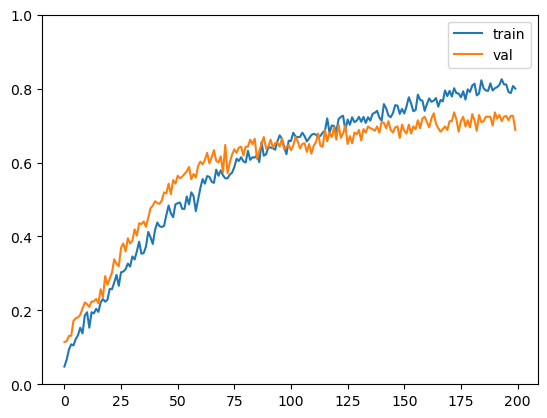

In [19]:
print("Train accuracy:", history.history["accuracy"][-1])
print("Validation accuracy:", history.history["val_accuracy"][-1])
print("Test accuracy:", model.evaluate(X_test, y_test, verbose=0)[1])
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.legend()
plt.ylim((0,1))
plt.show()

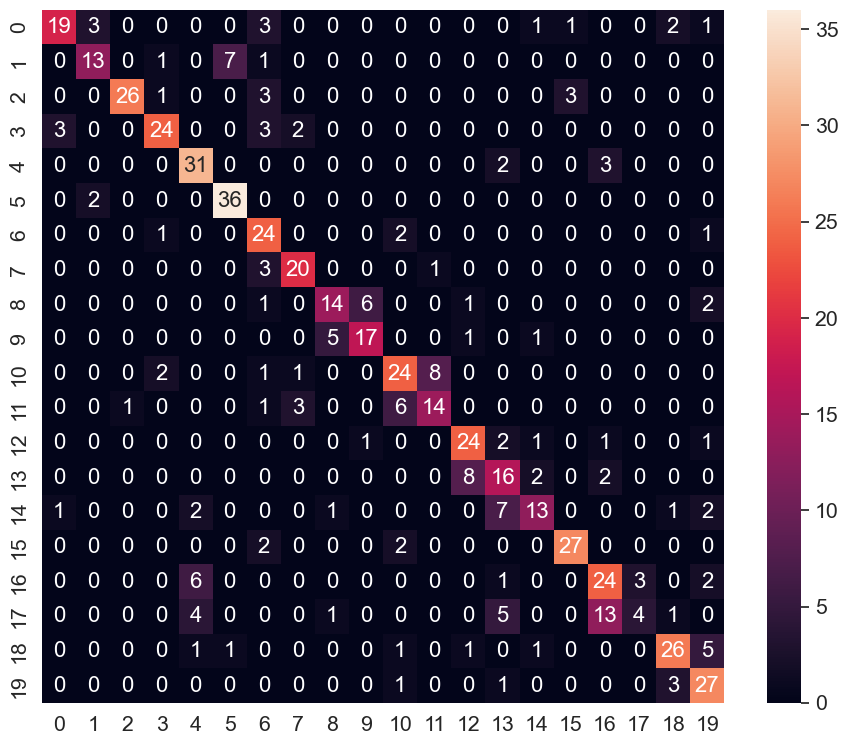

In [20]:
y_pred = model.predict(X_test, verbose=0)
y_pred_rd = np.argmax(y_pred, axis=1)
y_test_rd = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_rd, y_pred_rd)
df_cm = pd.DataFrame(cm, range(20), range(20))
plt.figure(figsize=(11,9))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

In [21]:
import time 

start = time.time()
y_prediction = model.predict(X_test) 
end = time.time()

print("Inference time: %f ms" % ((end - start)/X_test.shape[0] * 1000))

19/19 [==============================] - 0s 2ms/step
Inference time: 0.115342 ms


In [22]:
model.save('./save_model/rnn')

INFO:tensorflow:Assets written to: ./save_model/rnn/assets


INFO:tensorflow:Assets written to: ./save_model/rnn/assets


In [23]:
import joblib

joblib.dump(le, './save_model/label_encoder.joblib')

['./save_model/label_encoder.joblib']